# TV reconstruction for sparse angles

In [16]:
import numpy as np
import odl

In [17]:
# Parameters
lam = 0.01
data_matching = 'exact'
num_angles=22
num_angles=180
limited_angle=0.5
space = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20], shape=[512, 512])
angle_partition = odl.uniform_partition(0, np.pi*limited_angle, num_angles)
detector_partition = odl.uniform_partition(-30, 30, 512)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
ray_trafo = odl.tomo.RayTransform(space, geometry)
phantom = odl.phantom.shepp_logan(space, modified=True)
data = ray_trafo(phantom)

/home/w/wuebbel/.local/lib/python3.10/site-packages/odl/tomo/backends/skimage_radon.py:244: RuntimeWarning: The 'skimage' backend may be too slow for volumes of this size. Consider using 'astra_cpu', or 'astra_cuda' if your machine has an Nvidia GPU.
  warnings.warn(


In [18]:
gradient = odl.Gradient(space)

# Functional to enforce 0 <= x <= 1
f = odl.solvers.IndicatorBox(space, 0, 1)

if data_matching == 'exact':
    # Functional to enforce Ax = g
    # Due to the splitting used in the douglas_rachford_pd solver, we only
    # create the functional for the indicator function on g here, the forward
    # model is handled separately.
    indicator_zero = odl.solvers.IndicatorZero(ray_trafo.range)
    indicator_data = indicator_zero.translated(data)
elif data_matching == 'inexact':
    # Functional to enforce ||Ax - g||_2 < eps
    # We do this by rewriting the condition on the form
    # f(x) = 0 if ||A(x/eps) - (g/eps)||_2 < 1, infinity otherwise
    # That function (with A handled separately, as mentioned above) is
    # implemented in ODL as the IndicatorLpUnitBall function.
    # Note that we use right multiplication in order to scale in input argument
    # instead of the result of the functional, as would be the case with left
    # multiplication.
    eps = 5.0

    # Add noise to data
    raw_noise = odl.phantom.white_noise(ray_trafo.range)
    data += raw_noise * eps / raw_noise.norm()

    # Create indicator
    indicator_l2_ball = odl.solvers.IndicatorLpUnitBall(ray_trafo.range, 2)
    indicator_data = indicator_l2_ball.translated(data / eps) * (1 / eps)
else:
    raise RuntimeError('unknown data_matching')

# Functional for TV minimization
cross_norm = lam * odl.solvers.GroupL1Norm(gradient.range)

# --- Create functionals for solving the optimization problem ---

# Assemble operators and functionals for the solver
lin_ops = [ray_trafo, gradient]
g = [indicator_data, cross_norm]

# Create callback that prints the iteration number and shows partial results
callback = (odl.solvers.CallbackShow('Iterates', step=5, clim=[0, 1]) &
            odl.solvers.CallbackPrintIteration())

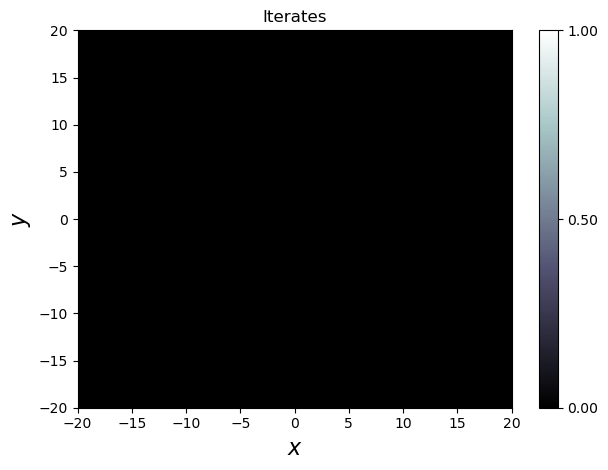

<Figure size 640x480 with 0 Axes>

iter = 0
iter = 1
iter = 2
iter = 3
iter = 4


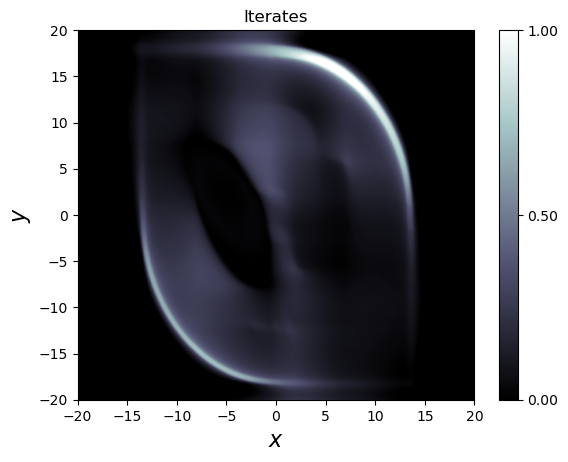

<Figure size 640x480 with 0 Axes>

iter = 5
iter = 6
iter = 7
iter = 8
iter = 9


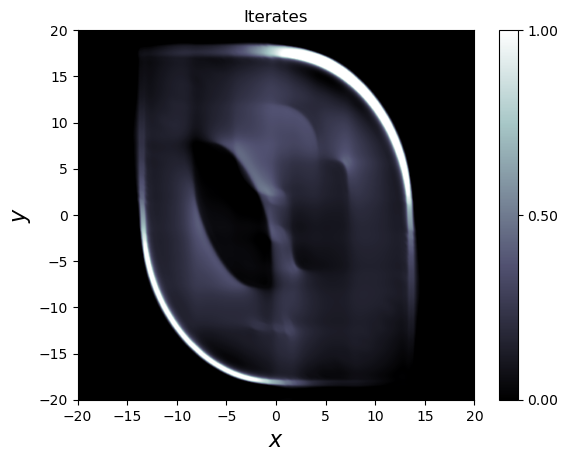

<Figure size 640x480 with 0 Axes>

iter = 10
iter = 11
iter = 12
iter = 13
iter = 14


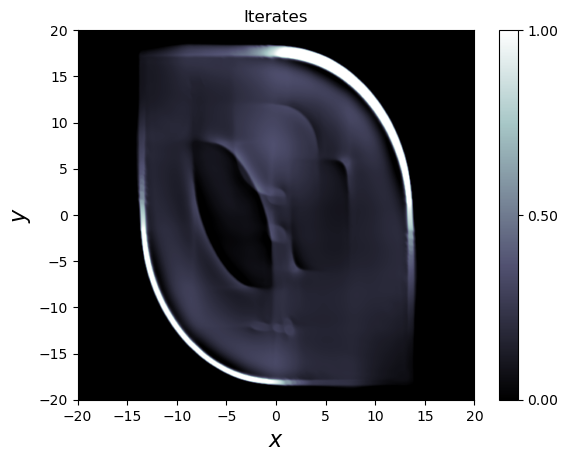

<Figure size 640x480 with 0 Axes>

iter = 15
iter = 16
iter = 17
iter = 18
iter = 19


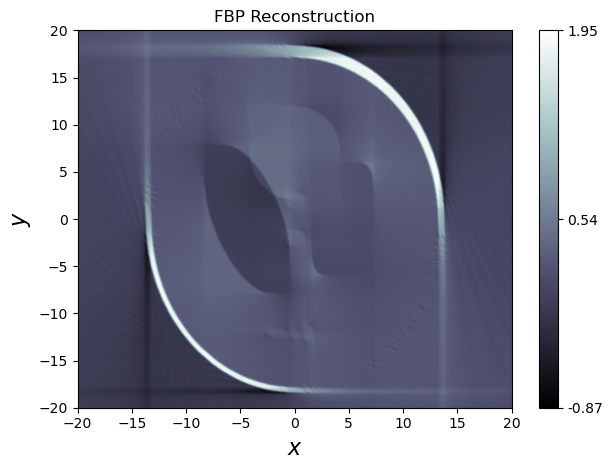

<Figure size 640x480 with 0 Axes>

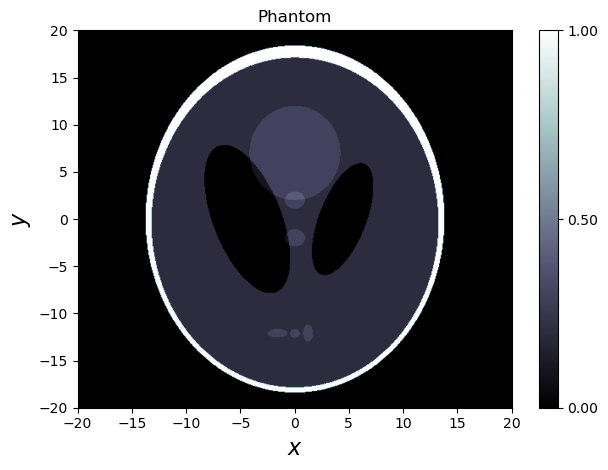

<Figure size 640x480 with 0 Axes>

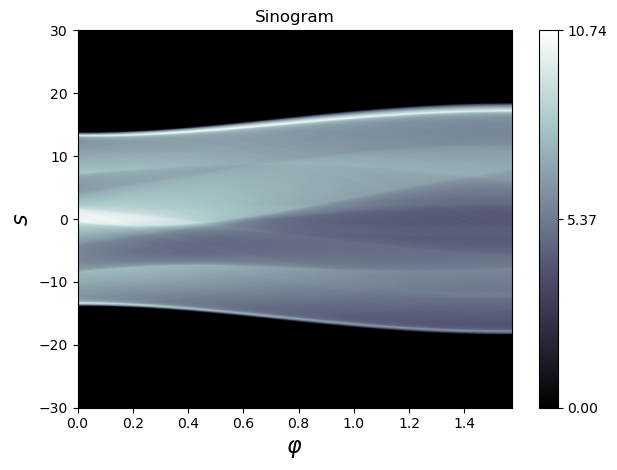

<Figure size 640x480 with 0 Axes>

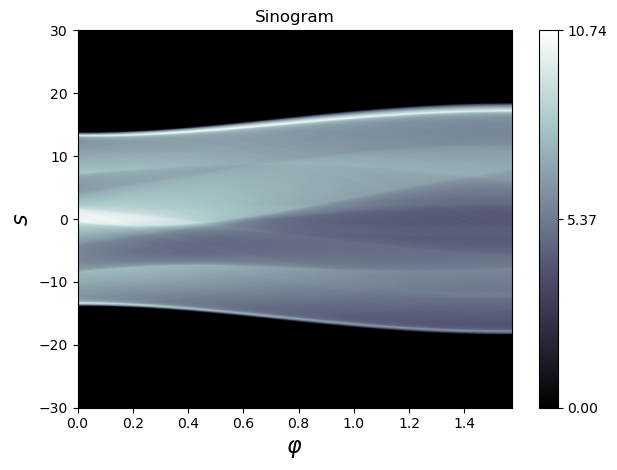

In [19]:
# Solve with initial guess x = 0.
# Step size parameters are selected to ensure convergence.
# See douglas_rachford_pd doc for more information.
x = ray_trafo.domain.zero()
odl.solvers.douglas_rachford_pd(x, f, g, lin_ops,
                                tau=0.1, sigma=[0.1, 0.02], lam=1.5,
                                niter=20, callback=callback)

# Compare with filtered back-projection
fbp_recon = odl.tomo.fbp_op(ray_trafo)(data)
fbp_recon.show('FBP Reconstruction')
phantom.show('Phantom')
data.show('Sinogram', force_show=True)